#  Detection of wind outages over W Europe and link with weather regime

In [1]:
import netCDF4
import xarray as xr
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.path as mpath

import pandas as pd

## Getting wind speed over land using CDO

In [2]:
ws = xr.open_dataset('./data/wind10_eur_19790101_20191231_LAND.nc')

In [3]:
ws_season = ws.groupby('time.season').mean('time')

In [4]:
lat  = ws.latitude.values
lon  = ws.longitude.values
latS=30
latN=80
lonW=-20
lonE=30
projection = ccrs.Orthographic(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2)
bounds = [(lonW, lonE, latS, latN)]

def make_boundary_path(lon,lat):
    lons,lats=np.meshgrid(lon,lat)
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],lats[1,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,1],lats[:,1]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

## Preliminary data visualisation

In [5]:
wind_levels = np.linspace(0,8,17)

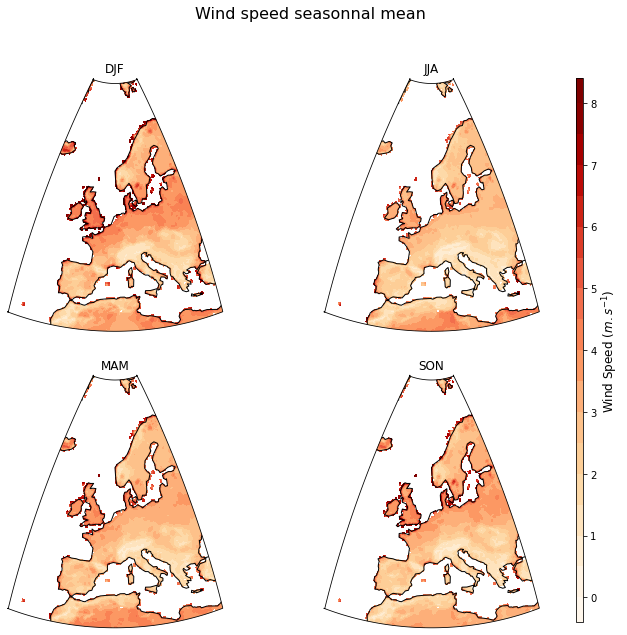

In [6]:
fig = plt.figure(figsize=(13, 10))

plt.suptitle('Wind speed seasonnal mean', fontsize=16)
for i, season in enumerate(ws_season.season) :
    ax = fig.add_subplot(2, 2, i+1, projection=projection)
    ax.coastlines()
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    boundary_path = make_boundary_path(lon, lat)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, ws_season.ws.sel(season = season), levels = wind_levels,
                     cmap='OrRd', extend='both', transform=ccrs.PlateCarree())
    ax.set_title(season.values)
    
cb = fig.colorbar(cf, ax = fig.axes, orientation='vertical', aspect=65, extendrect='True')
cb.set_label('Wind Speed ($m.s^{-1}$)', fontsize=12)

In [7]:
ws_temp_var = ws.ws.std('time') - ws.ws.std()

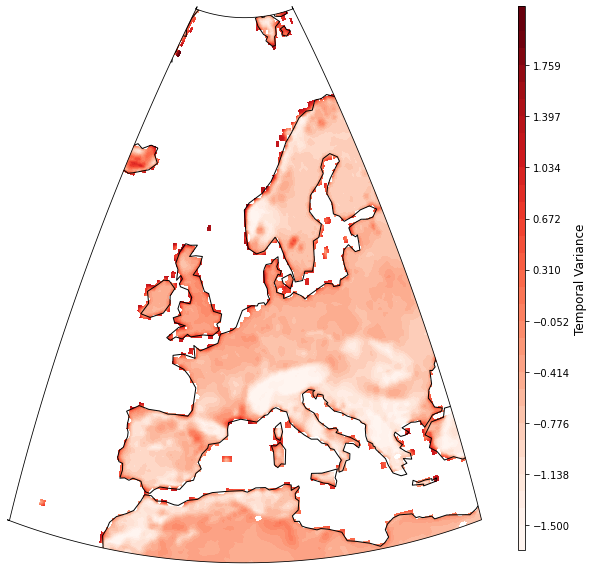

In [8]:
fig = plt.figure(figsize=(13, 10))

ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon, lat)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon, lat, ws_temp_var, levels = np.linspace(-1.5,2,30),
                 cmap='Reds', extend='both', transform=ccrs.PlateCarree())
    
cb = fig.colorbar(cf, ax = fig.axes, orientation='vertical', aspect=65, extendrect='True')
cb.set_label('Temporal Variance', fontsize=12)

# Wind Outage Index (WOI) over western Europe

Defining a smaller area more representative of western Europe.
+ note : does not take wind turbine density into account
    + rapid research : no easy data, <b> remember to ask <b/>

In [9]:
latS_zoom=37
latN_zoom=60
lonW_zoom=-10
lonE_zoom=25
hres = 0.25 #degree
zoom_bounds = [(lonW_zoom, lonE_zoom, latS_zoom, latN_zoom)]
lon_zoom = np.arange(lonW_zoom,lonE_zoom+hres,hres)
lat_zoom = np.arange(latS_zoom,latN_zoom+hres,hres)

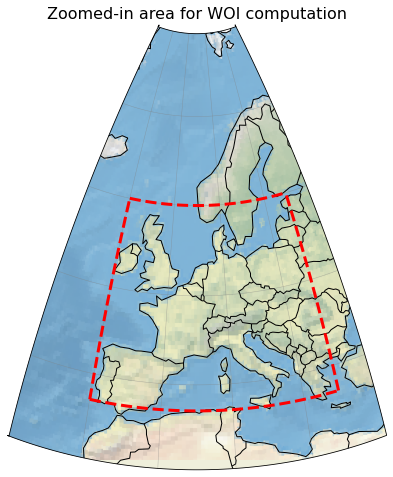

In [10]:
fig = plt.figure(figsize=(11, 8))

ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.set_title('Zoomed-in area for WOI computation', fontsize = 16)
ax.stock_img()
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon, lat)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
ax.plot([lonW_zoom]*len(lat_zoom), lat_zoom, transform=ccrs.PlateCarree(), color = 'red', ls = '--', lw = 3)
ax.plot([lonE_zoom]*len(lat_zoom), lat_zoom, transform=ccrs.PlateCarree(), color = 'red', ls = '--', lw = 3)
ax.plot(lon_zoom, [latN_zoom]*len(lon_zoom), transform=ccrs.PlateCarree(), color = 'red', ls = '--', lw = 3)
ax.plot(lon_zoom, [latS_zoom]*len(lon_zoom), transform=ccrs.PlateCarree(), color = 'red', ls = '--', lw = 3)

ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
plt.show()

### Trying to define WOI (over land) and first visualisations

#### WOI using a simple spatial mean and daily anomalies

In [11]:
ws_zoom = ws.sel(longitude = lon_zoom, latitude = lat_zoom)

In [12]:
ws_index = ws_zoom.mean(dim = ['latitude','longitude'])

In [13]:
ws_index_day_mean = xr.concat([
    ws_index.groupby('time.dayofyear').mean('time').roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[:15],
    ws_index.groupby('time.dayofyear').mean('time').ws.rolling(dayofyear=30, center=True).mean().dropna('dayofyear'),
    ws_index.groupby('time.dayofyear').mean('time').roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[-14:]],
    dim = 'dayofyear')

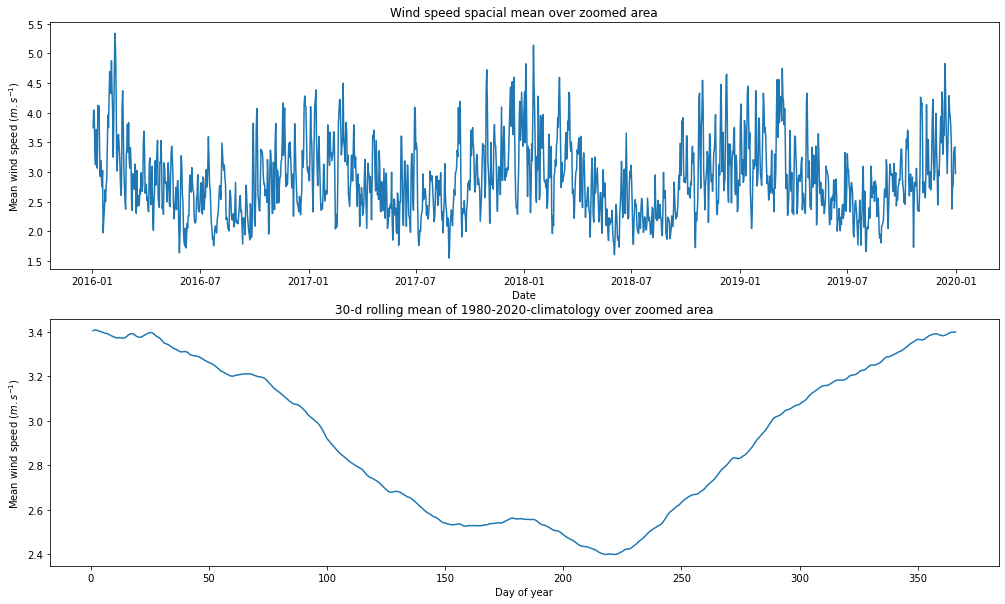

In [14]:
fig = plt.figure(figsize=(17, 10))

ax = fig.add_subplot(2, 1, 1)
ax.set_title('Wind speed spacial mean over zoomed area')
ax.plot(ws_index.time.values[-365*4:], ws_index.ws[-365*4:])
ax.set_xlabel('Date')
ax.set_ylabel('Mean wind speed ($m.s^{-1}$)')

ax = fig.add_subplot(2, 1, 2)
ax.set_title('30-d rolling mean of 1980-2020-climatology over zoomed area')
ax.plot(ws_index_day_mean.dayofyear, ws_index_day_mean)
ax.set_xlabel('Day of year')
ax.set_ylabel('Mean wind speed ($m.s^{-1}$)')

plt.tight_layout
plt.show()

In [15]:
ws_index_danom = ws_index.ws.groupby('time.dayofyear') - ws_index_day_mean

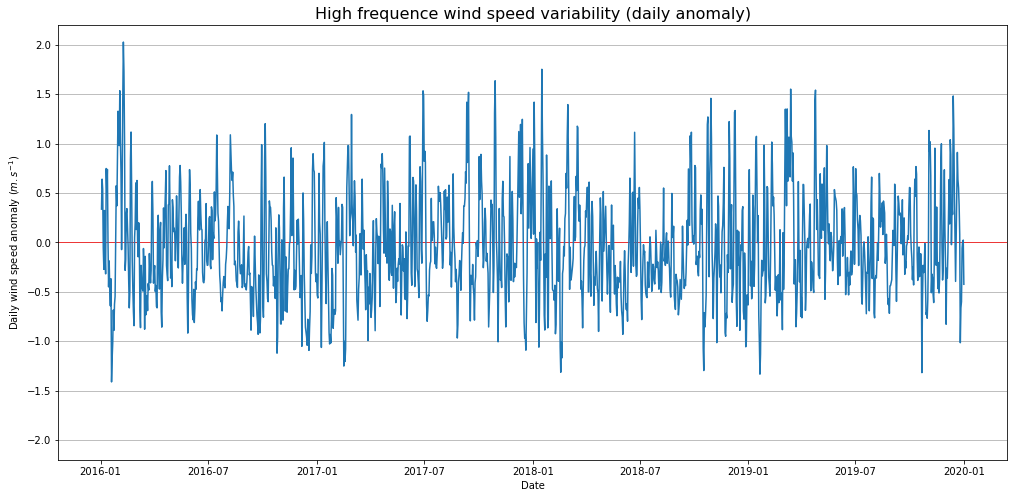

In [16]:
fig = plt.figure(figsize=(17, 8))
ws_index_danom_zoom = ws_index_danom[-365*4:]

ax = fig.add_subplot(1, 1, 1)
ax.set_title('High frequence wind speed variability (daily anomaly)', fontsize = 16)
ax.set_xlabel('Date')
ax.set_ylabel('Daily wind speed anomaly ($m.s^{-1}$)')
ax.set_ylim(-2.2,2.2)
ax.plot(ws_index_danom_zoom.time.values, ws_index_danom_zoom, zorder = 3)
ax.grid(axis = 'y', zorder = 1)
ax.axhline(0, color='red', lw = 0.7, zorder = 2)
plt.show()

+ \+ de variabilité en hiver ? (verif == std après groupby(season)

In [17]:
ws_index_danom_std = ws_index_danom.groupby('time.season').std('time')

In [96]:
ws_index_danom_std.values

array([0.69541252, 0.44194263, 0.54516953, 0.57913774])

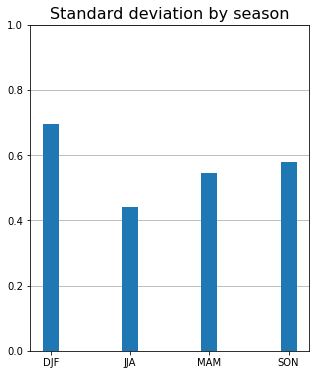

In [123]:
fig = plt.figure(figsize=(5, 6))

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Standard deviation by season', fontsize = 16)
ax.bar(ws_index_danom_std.season, ws_index_danom_std.values, width = 0.2, zorder = 2)
ax.grid(axis = 'y',zorder = 1)
ax.set_ylim(0,1)
plt.show()

In [105]:
ws_index.ws.groupby('time.season').quantile([0.01,0.25,0.5,0.75,0.99])

<xarray.DataArray 'ws' (season: 4, quantile: 5)>
array([[2.07923065, 2.84506065, 3.27818096, 3.77945244, 5.20771616],
       [1.64305797, 2.1583944 , 2.44280529, 2.78188258, 3.63484293],
       [1.78546392, 2.46976584, 2.8184942 , 3.23418933, 4.58393799],
       [1.76381911, 2.5405513 , 2.91860032, 3.34738386, 4.62323666]])
Coordinates:
  * quantile  (quantile) float64 0.01 0.25 0.5 0.75 0.99
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'

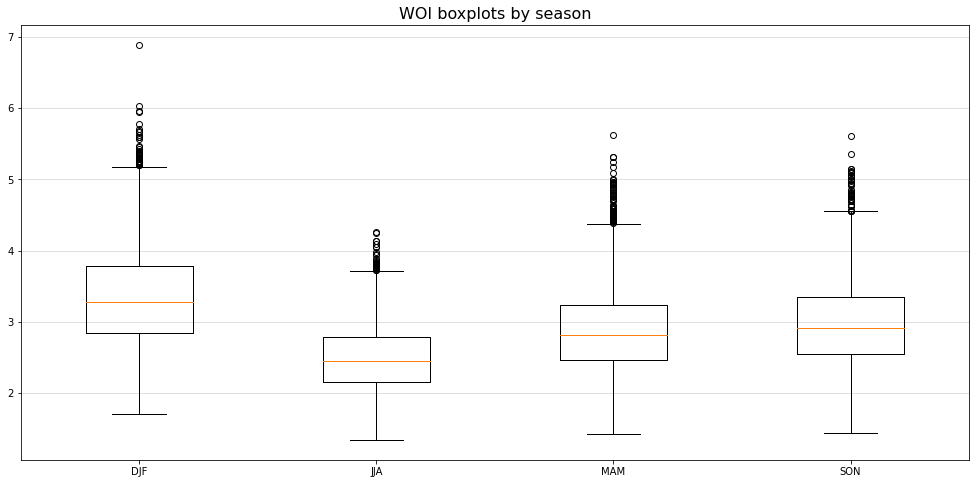

In [124]:
fig = plt.figure(figsize=(17, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_title('WOI boxplots by season', fontsize = 16)
test=[]
for season in ws_index_danom_std.season.values :
    test.append(ws_index.ws.groupby('time.season')[season])
ax.boxplot(test, labels = ws_index_danom_std.season.values)
ax.grid(axis = 'y', alpha = 0.5)
plt.show()

+ Idea to define WOI :
    + simple spatial mean over land could be replaced by a <b>wind-turbine-density-weighted-mean</b> but
        + need for data (seems that no free dataset is available)
        + exclude potential future windfarm location and high power density areas
    + detection of wind outage using WOI could be
        + catching statisiticaly weak anomaly (like -1.5 or -2 $\sigma$) on usually weak wind period
        + using a simple wind speed theshold (statistically defined ?)